# Generic Scaling-up Framework

**Generic framework with BASE_SCALE concept**

Framework for scaling up from any base scale unit to different spatial boundaries using area weighting.

## Key Concepts
- **BASE_SCALE**: The atomic unit (finest resolution) that all other scales aggregate from
- **AGGREGATION_SCALES**: Larger spatial boundaries that contain multiple base scale units
- **NULL aggregator_df**: BASE_SCALE acts as identity aggregator_df (no spatial aggregation)

In [2]:
import json
    
with open("test_framework.ipynb") as pynb:
    try:
        report = json.load(pynb)
    except Exception as e:
        print(str(e))

'charmap' codec can't decode byte 0x8f in position 130090: character maps to <undefined>


In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
from pathlib import Path

# Set paths
from scaling_up_framework_functions import (
    SpatialScale,
    plot_spatial_hierarchy,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration and Setup

In [11]:
# =============================================================================
# TEST FILE PATHS
# =============================================================================
SPATIAL_PATH = Path("./input/spatial/")
DATA_PATH = Path("./input/csv/")
OUTPUT_PATH = Path("./output/")

# Test functional group rules
GROUP_RULES = {
    "BaseUnits": {"vegetation": ["Forest", "Grassland"], "water": ["Wetland"]}
}

# =============================================================================
# PROJECTION FOR SPATIAL DATA
# =============================================================================
DEFAULT_CRS = "EPSG:3577"


# Functional group rules for different base scales
# The rules dictionary maps the base scale name to a dictionary of functional group rules.
# Each functional group rule is a dictionary where the keys are the functional group names
# keyword matching of types to groups is always case insensitive
# the structure is group_name: keywords in the values of the configured type_field

GROUP_RULES = {
    "ANAE": {
        "river red gum woodland": ["river red gum", "woodland"],
        "river red gum swamps and forests": ["river red gum"],
        "black box": ["black box"],
        "coolibah": ["coolibah"],
        "lignum": ["lignum"],
        "cooba": ["cooba"],
        "shrubland": ["f2.4: shrubland riparian zone or floodplain"],
        "submerged lake": ["permanent lake", "permanent wetland", "aquatic bed"],
        "tall reed beds": ["tall emergent marsh"],
        "grassy meadows": ["grass", "meadow"],
        "herbfield": ["forb marsh", "temporary wetland", "temporary lake"],
        "clay pan": ["clay"]
    },
    "Rivers": {
        "Permanent Lowland": ["permanent lowland"],
        "Temporary Lowland": ["temporary lowland"],
        "Other temporary": ["temporary transitional, "],
    }
}



# Setup test environment
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

## Load Base Scale Data (Atomic Units)

**Grouping Behavior:**
- `type_field = None`: All features aggregated together
- `type_field` defined + `GROUP_RULES`: Uses functional groups
- `type_field` defined, no `GROUP_RULES`: Uses original type values

Loading ANAE data from ANAEv3_BWS.shp.zip...
   Requested: ['Area_Ha', 'UID', 'ANAE_TYPE', 'geometry']
   Using CRS: GDA94 / Australian Albers.
⚠ Found 59 invalid geometries.
   Attempting to fix invalid geometries...
   All geometries successfully fixed.
   No specific metric fields chosen so loading all columns.
   Loaded: ['UID', 'ANAE_TYPE', 'Area_Ha', 'ManFP', 'Shape_Leng', 'Shape_Area']
   Found 597 multi-part geometries in ANAE data.  Calculations will proceed OK. Just letting you know!  
   Detected geometry type: polygon (106551 features)
No metric fields specified. Inferred: ['ManFP', 'Shape_Leng', 'Shape_Area']
Plotting ANAE...


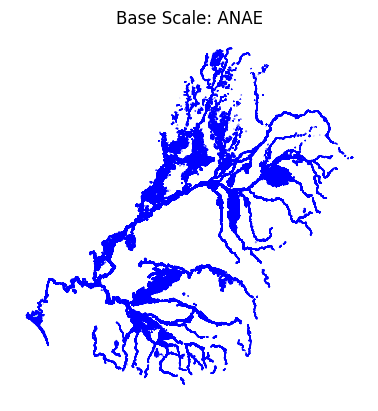

In [28]:
# Load the base spatial scale
anae = SpatialScale(
    name="ANAE",
    source=SPATIAL_PATH / "ANAEv3_BWS.shp.zip",
    unique_id_fields="UID",
    weighting_field="Area_Ha",
    #metric_fields="NDVI",  
    measure_multiplier=None,
    type_field="ANAE_TYPE",
    is_base_scale=True,
    default_crs="EPSG:3577"
)

anae.plot()


## Load Aggregation Scale Boundaries

In [29]:
# Define aggregation scales
AGGREGATION_CONFIGS = {
    "Valley": {"source_file_path": SPATIAL_PATH / "BWSRegions.shp.zip", "unique_id": "BWS_Region"},
    "DIWA": {"source_file_path": SPATIAL_PATH / "DIWA_complex.shp.zip", "unique_id": "WNAME"},
    "Ramsar": {"source_file_path": SPATIAL_PATH / "ramsar_wetlands.shp.zip", "unique_id": ["RAMSAR_NAM", "WETLAND_NA"]},
    "NorthSouthBasin": {"source_file_path":SPATIAL_PATH / "Northern_Southern_Basin.shp.zip", "unique_id": "Region"}
}


valley = SpatialScale(
    name="Valley",
    source=SPATIAL_PATH / "BWSRegions.shp.zip",
    unique_id_fields="BWS_Region",
)

diwa = SpatialScale(
    name="DIWA",
    source=SPATIAL_PATH / "DIWA_complex.shp.zip",
    unique_id_fields="WNAME",
)
ramsar = SpatialScale(
    name="Ramsar",
    source=SPATIAL_PATH / "ramsar_wetlands_MDB.shp.zip",
    unique_id_fields=["RAMSAR_NAM", "WETLAND_NA"],
)
ns_basin = SpatialScale(
    name="NorthSouthBasin",
    source=SPATIAL_PATH / "Northern_Southern_Basin.shp.zip",
    unique_id_fields="Region",
)



Loading Valley data from BWSRegions.shp.zip...
   Requested: ['BWS_Region', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['BWS_Region', 'AREA_SQKM']
   Found 3 multi-part geometries in Valley data.  Calculations will proceed OK. Just letting you know!  
   Detected geometry type: polygon (20 features)
No metric fields specified. Inferred: ['AREA_SQKM']
Loading DIWA data from DIWA_complex.shp.zip...
   Requested: ['WNAME', 'geometry']
   Using CRS: GDA94 / Australian Albers.
⚠ Found 7 invalid geometries.
   Attempting to fix invalid geometries...
   All geometries successfully fixed.
   No specific metric fields chosen so loading all columns.
   Loaded: ['OBJECTID', 'WNAME', 'AreaHa', 'Shape_Leng', 'Shape_Area', 'tmax_cumul']
   Found 68 multi-part geometries in DIWA data.  Calculations will proceed OK. Just letting you know!  
   Detected geometry type: polygon (202 features)
No 

# Plot the hierarchy

Plotting ANAE with 4 aggregation scales...


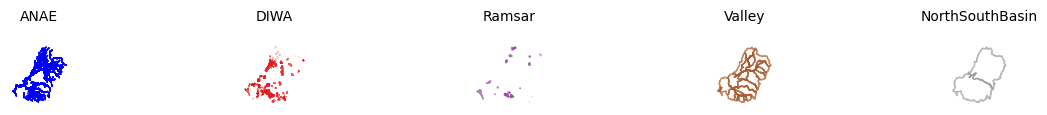

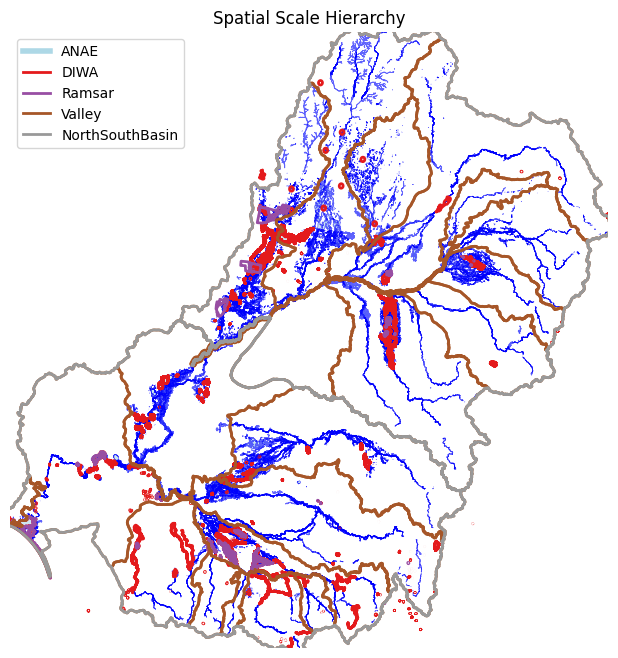

In [30]:

#order smallest to biggest
plot_spatial_hierarchy(anae, diwa, ramsar, valley, ns_basin)

## Process Metric Data

In [31]:

anae.join_data(
    data_path=DATA_PATH / "NDVI_2001-2024_ANAEv3_annual_MODIS.zip",
    pivot_row_id="UID", #make this a string
    pivot_columns="year",
    pivot_values="NDVI",
    
)


print (anae.data.drop(columns=['geometry']).head(10))


No metric fields specified. Inferred: ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
⚠ Dropping 64 invalid rows (missing values or not numeric). 270565 rows remain.
Joined external data from input\csv\NDVI_2001-2024_ANAEv3_annual_MODIS.zip on '['UID']'
         UID                                    ANAE_TYPE   Area_Ha  ManFP  \
0  r1dtvqu5m  F4: Unspecified riparian zone or floodplain  3.972622      0   
1  r1dtygfug       Pt2.1.2: Temporary tall emergent marsh  3.316279      1   
2  r1dtyggsf           Etd1.2.1: Tide dominated saltmarsh  2.217581      1   
3  r1dtyjqxg                     Pt4.2: Temporary wetland  5.736414      0   
4  r1dtyjxp1       Pt2.1.2: Temporary tall emergent marsh  4.490608      1   
5  r1dtym0ms       Pt2.1.2: Temporary tall emergent marsh  2.965308      1   
6  r1dtyr729                            Pt3.1.2: Clay p

## Analysis and Output Generation

In [36]:
# Geometry-weighted mean NDVI aggregated from base to regions
region_results = anae.aggregate_to(
    ramsar,
    metric_columns=list(range(2001,2025)), #last value excluded 2001-2024
    method="weighted_mean",  
    weighting_field="Area_Ha",#Could be omitted as Area is the default for polygons
    reclass_map = GROUP_RULES["ANAE"],
    keep_unmatched_types =False,
    result_name="2001-2024_NDVI_area_weighted_mean",
)

Using 'Area_Ha' for 'Area_Ha_weighted' aggregation
⚠ Warning Result '2001-2024_NDVI_area_weighted_mean' exists. Using '2001-2024_NDVI_area_weighted_mean_1' instead.
Using cached spatial join: Ramsar_intersects
Reclassifying 'ANAE_TYPE' into new groups 'regrouped' using substring match from reclass map...
Dropped 28 types that did not match any re-grouping rules.Keeping 6101 re-grouped rows.
Set option 'keep_unmatched_types=True' to retain unmatched types.
Aggregating by ['RAMSAR_NAM', 'WETLAND_NA', '_grp_', 'regroup', 'regroup', 'regrouped'] using 'weighted_mean'


KeyError: "['_grp_', 'regroup'] not in index"

## Summary and Validation

In [35]:

print (ramsar.results["2001-2024_NDVI_area_weighted_mean"]["regroup"])

KeyError: 'regroup'